<a href="https://colab.research.google.com/github/SanyaShresta25/Garbage-Classification-Using-CNN-AlexNet/blob/main/Garbage_Classification_Using_CNN%26AlexNet(v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Garbage Classification using AlexNet**
In this notebook, we'll implement a garbage classification system using the AlexNet CNN architecture. We'll be working with a dataset containing images of 6 different garbage categories: cardboard, glass, metal, paper, plastic, and trash.

# **1. Setup and Data Import**


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
import kagglehub
garbage_classification_path = kagglehub.dataset_download('asdasdasasdas/garbage-classification')
print('Data source import complete.')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Data source import complete.


# **2. Configuration Parameters**

In [3]:
# Constants
train_dir = '/kaggle/input/garbage-classification/Garbage classification/Garbage classification'
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

IMAGE_SIZE = (384, 512)  # Image dimensions
BATCH_SIZE = 4  # Reduced due to larger image size
EPOCHS = 30  # Maximum training epochs

# **3. Data Exploration**


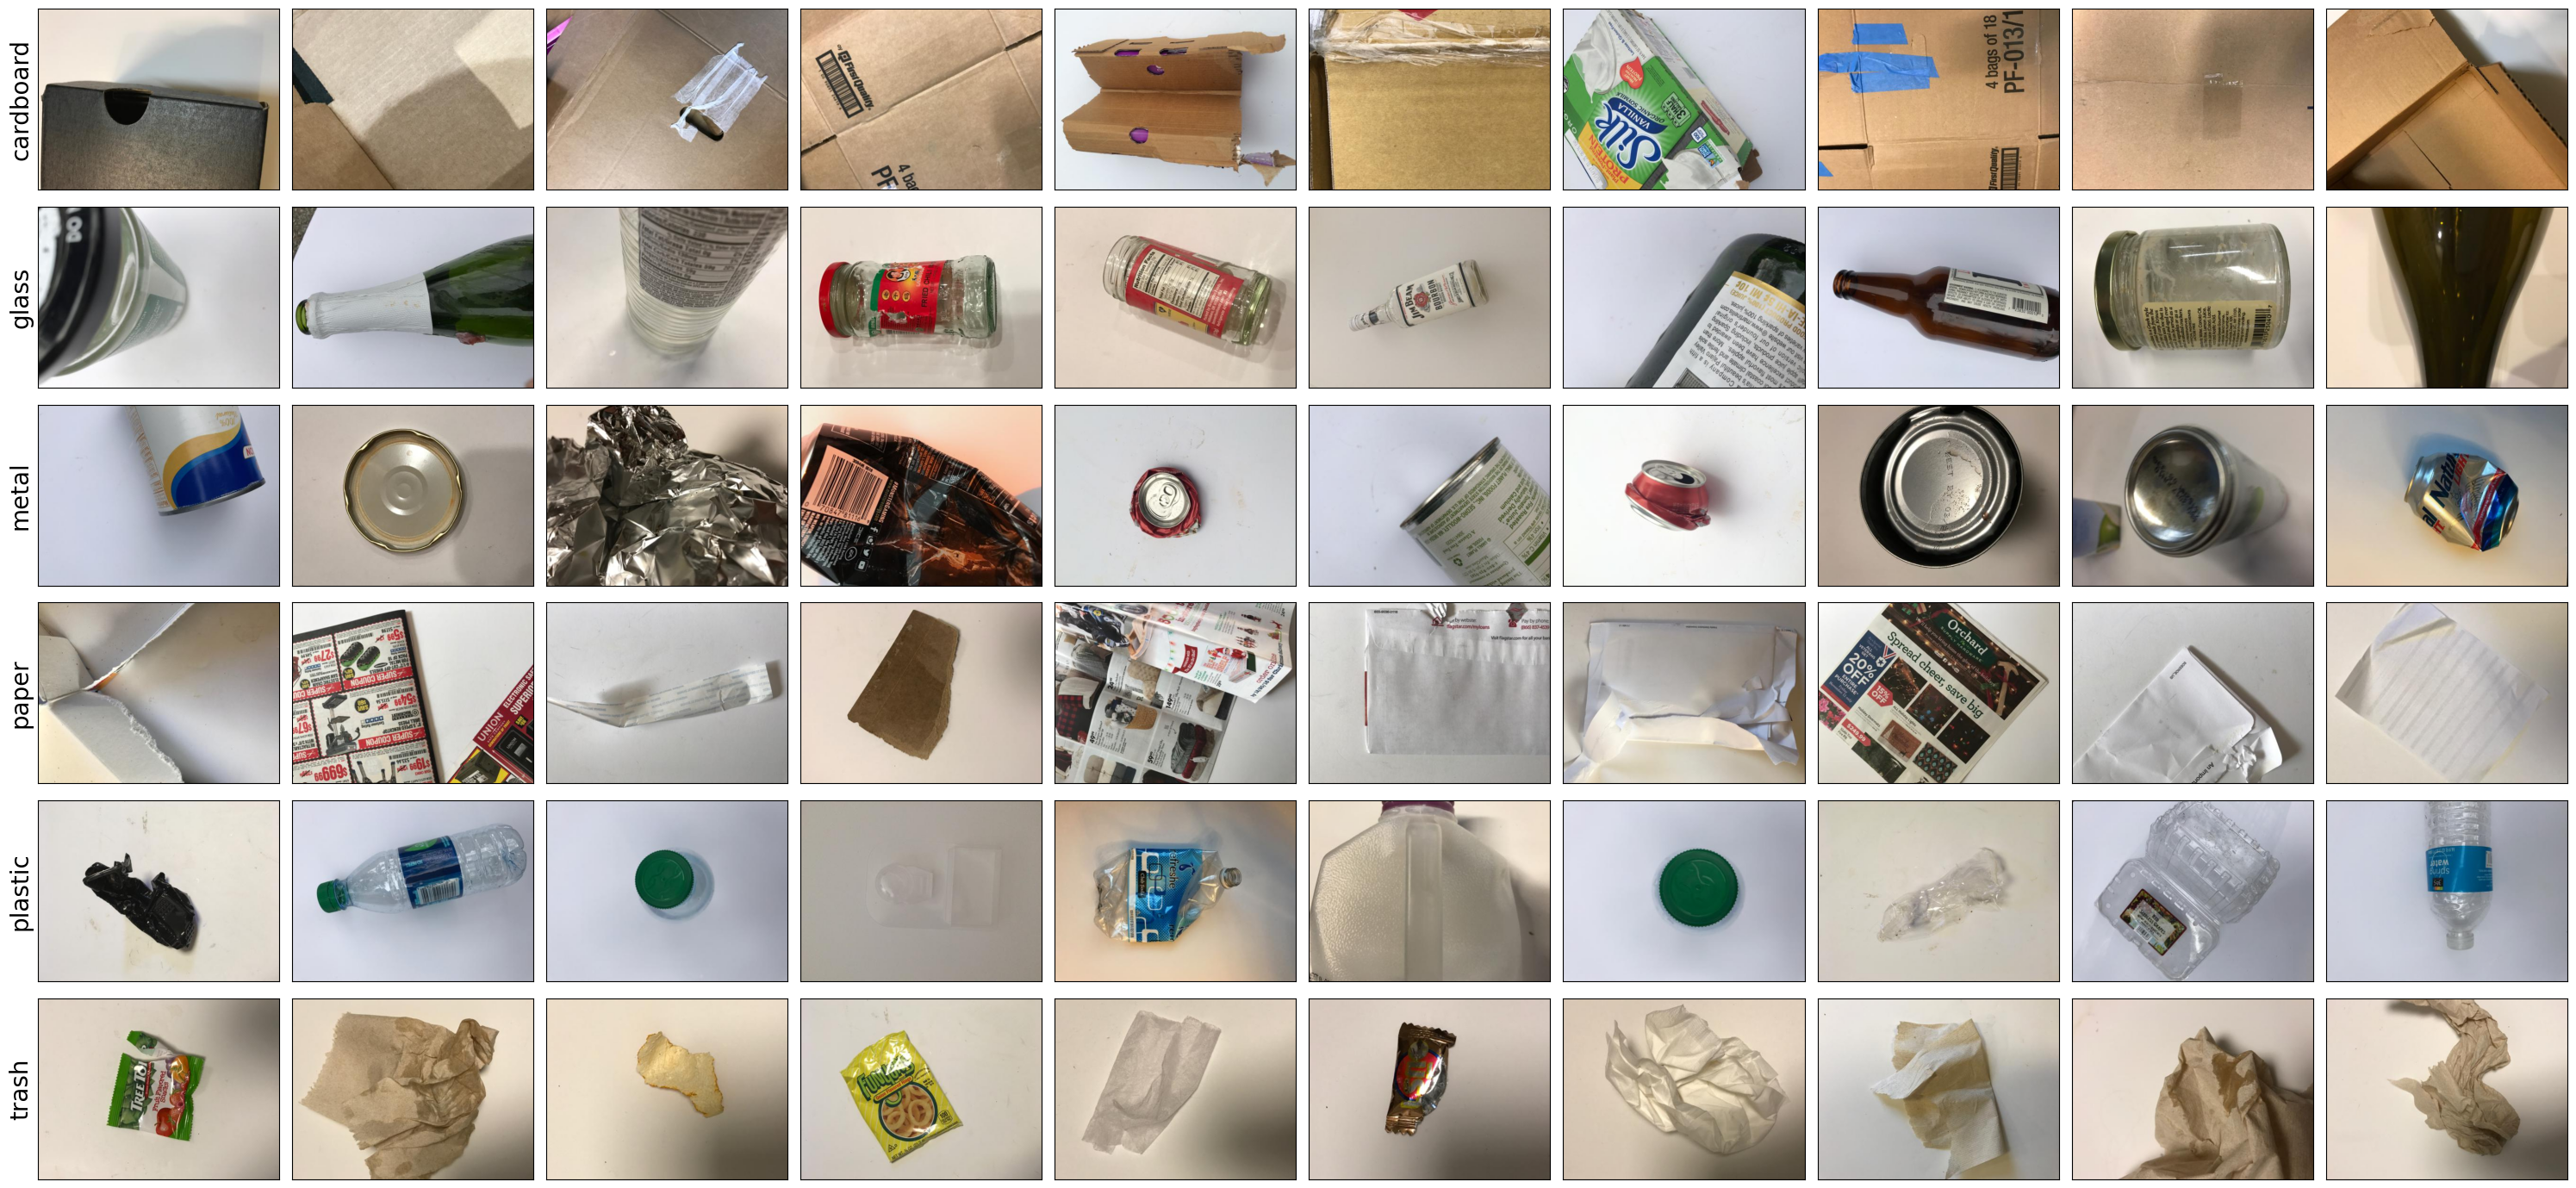

In [4]:
# Display sample images from each class
plt.figure(figsize=(30, 14))
for i in range(6):
    directory = os.path.join(train_dir, labels[i])
    for j in range(10):
        path = os.path.join(directory, os.listdir(directory)[j])
        img = mpimg.imread(path)
        plt.subplot(6, 10, i*10 + j + 1)
        plt.imshow(img)
        if j == 0:
            plt.ylabel(labels[i], fontsize=20)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.tight_layout()
plt.show()

# **4. Data Preparation**

In [5]:
# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

# Create data generators function
def create_generators():
    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        class_mode='sparse', subset='training', shuffle=True
    )

    validation_generator = train_datagen.flow_from_directory(
        train_dir, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
        class_mode='sparse', subset='validation', shuffle=False
    )

    return train_generator, validation_generator

# **5. AlexNet Model Architecture**

In [6]:
# AlexNet model creation function
def create_alexnet(dropout_rate=0.5, learning_rate=0.0001):
    model = Sequential([
        # Layer 1: Conv -> ReLU -> Pool
        Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='same', input_shape=(*IMAGE_SIZE, 3)),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        BatchNormalization(),

        # Layer 2: Conv -> ReLU -> Pool
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        BatchNormalization(),

        # Layer 3: Conv -> ReLU
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),

        # Layer 4: Conv -> ReLU
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),

        # Layer 5: Conv -> ReLU -> Pool
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        BatchNormalization(),

        # Flatten
        Flatten(),

        # FC Layers
        Dense(4096, activation='relu'),
        Dropout(dropout_rate),

        Dense(4096, activation='relu'),
        Dropout(dropout_rate),

        # Output Layer
        Dense(6, activation='softmax')  # 6 classes for garbage classification
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Display model summary
    model.summary()

    return model

# **6. Training History Visualization**

In [7]:
# Function to plot training history
def plot_training_history(history, title):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss - {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# **7. Model Evaluation Function**

In [8]:
# Evaluate model function
def evaluate_model(model, validation_generator, title):
    print(f"\n--- Evaluating {title} ---")

    # Get predictions
    val_preds = model.predict(validation_generator)
    y_pred = np.argmax(val_preds, axis=1)
    y_true = validation_generator.classes

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_true)
    print(f"Validation Accuracy: {accuracy:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap='BuPu', fmt='g',
                xticklabels=labels, yticklabels=labels,
                linewidths=0.5, linecolor='white')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=labels))

    # Class-wise Accuracy
    print("\nClass-wise Accuracy:")
    for i, label in enumerate(labels):
        correct = np.sum((y_pred == y_true) & (y_true == i))
        total = np.sum(y_true == i)
        print(f"{label}: {correct/total:.2%}")

    return accuracy

# **8. Hyperparameter Tuning**

In [9]:
# Hyperparameter tuning
def hyperparameter_tuning():
    # Hyperparameter grid
    dropout_rates = [0.3, 0.5]  # AlexNet originally used 0.5
    learning_rates = [0.001, 0.0001]

    # Store results
    results = []

    for dropout in dropout_rates:
        for lr in learning_rates:
            print(f"\n\n===== Training AlexNet with dropout={dropout}, learning_rate={lr} =====")

            # Create generators
            train_generator, validation_generator = create_generators()

            # Create and compile model
            model = create_alexnet(dropout_rate=dropout, learning_rate=lr)

            # Define callbacks
            early_stopping = EarlyStopping(
                monitor='val_accuracy',
                patience=5,
                restore_best_weights=True
            )

            model_checkpoint = ModelCheckpoint(
                f'alexnet_garbage_dropout{dropout}_lr{lr}.h5',
                monitor='val_accuracy',
                save_best_only=True,
                mode='max'
            )

            # Train the model
            history = model.fit(
                train_generator,
                epochs=EPOCHS,
                validation_data=validation_generator,
                callbacks=[early_stopping, model_checkpoint],
                verbose=1
            )

            # Plot training history
            plot_training_history(history, f'AlexNet, Dropout={dropout}, LR={lr}')

            # Evaluate model
            accuracy = evaluate_model(model, validation_generator, f'AlexNet, Dropout={dropout}, LR={lr}')

            # Store results
            results.append({
                'dropout': dropout,
                'learning_rate': lr,
                'accuracy': accuracy,
                'epochs_trained': len(history.history['accuracy']),
                'val_loss': min(history.history['val_loss']),
                'model_path': f'alexnet_garbage_dropout{dropout}_lr{lr}.h5'
            })

    # Create results dataframe
    results_df = pd.DataFrame(results)
    print("\n===== AlexNet Hyperparameter Tuning Results =====")
    print(results_df)

    # Find best model
    best_model_info = results_df.loc[results_df['accuracy'].idxmax()]
    print("\n===== Best AlexNet Model =====")
    print(f"Dropout: {best_model_info['dropout']}")
    print(f"Learning Rate: {best_model_info['learning_rate']}")
    print(f"Accuracy: {best_model_info['accuracy']:.4f}")
    print(f"Epochs Trained: {best_model_info['epochs_trained']}")
    print(f"Validation Loss: {best_model_info['val_loss']:.4f}")

    # Plot all results
    plt.figure(figsize=(10, 6))
    for idx, row in results_df.iterrows():
        plt.scatter(row['learning_rate'], row['accuracy'],
                   s=100, label=f"Dropout={row['dropout']}")

    plt.xscale('log')
    plt.xlabel('Learning Rate (log scale)')
    plt.ylabel('Validation Accuracy')
    plt.title('AlexNet Hyperparameter Tuning Results')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Load and return best model
    best_model = load_model(best_model_info['model_path'])
    return best_model, best_model_info

# **9. Run Hyperparameter Search**



===== Training AlexNet with dropout=0.3, learning_rate=0.001 =====
Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 128, 96)    │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 63, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 47, 63, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 63, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 31, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 31, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 31, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 23, 31, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 23, 31, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 42240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   173,019,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,577,734 (738.44 MB)

 Trainable params: 193,574,982 (738.43 MB)

 Non-trainable params: 2,752 (10.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.2464 - loss: 56.4464

506/506 ━━━━━━━━━━━━━━━━━━━━ 182s 331ms/step - accuracy: 0.2464 - loss: 56.3853 - val_accuracy: 0.2803 - val_loss: 9.2355
Epoch 2/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 130s 257ms/step - accuracy: 0.2357 - loss: 5.5785 - val_accuracy: 0.2406 - val_loss: 2.5227
Epoch 3/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 123s 242ms/step - accuracy: 0.2840 - loss: 2.7563 - val_accuracy: 0.2048 - val_loss: 4.4710
Epoch 4/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 123s 243ms/step - accuracy: 0.2728 - loss: 2.3976 - val_accuracy: 0.2505 - val_loss: 1.8166
Epoch 5/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.2812 - loss: 1.9990

506/506 ━━━━━━━━━━━━━━━━━━━━ 151s 299ms/step - accuracy: 0.2812 - loss: 1.9989 - val_accuracy: 0.2863 - val_loss: 1.9634
Epoch 6/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 130s 257ms/step - accuracy: 0.2788 - loss: 2.2033 - val_accuracy: 0.2366 - val_loss: 1.7435
Epoch 7/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 132s 260ms/step - accuracy: 0.2270 - loss: 1.7659 - val_accuracy: 0.2485 - val_loss: 1.8938
Epoch 8/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 128s 253ms/step - accuracy: 0.2454 - loss: 1.8254 - val_accuracy: 0.2406 - val_loss: 1.7476
Epoch 9/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 144s 284ms/step - accuracy: 0.2406 - loss: 1.7901 - val_accuracy: 0.2763 - val_loss: 1.9585
Epoch 10/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 124s 245ms/step - accuracy: 0.2643 - loss: 1.7596 - val_accuracy: 0.2346 - val_loss: 1.7250


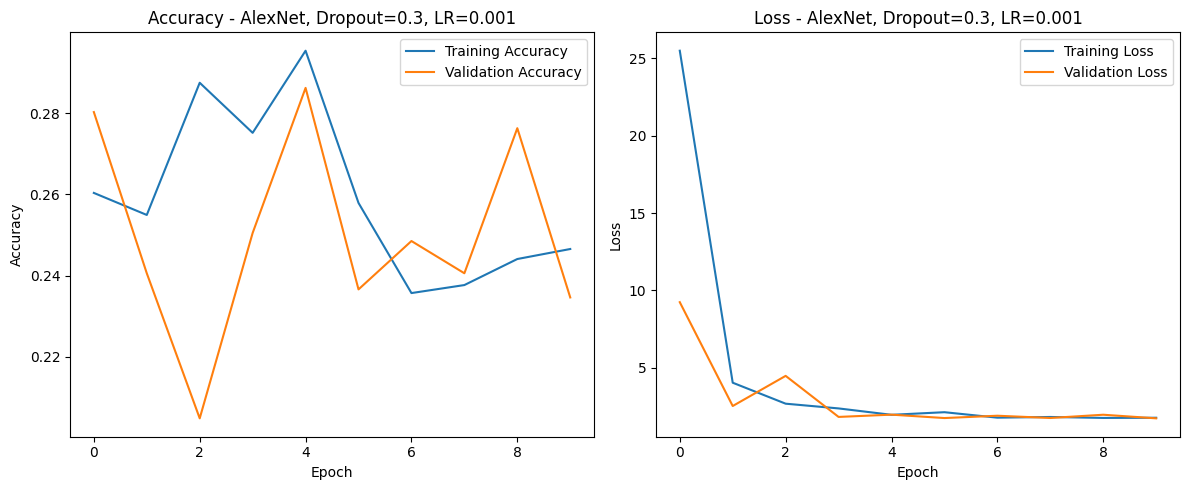


--- Evaluating AlexNet, Dropout=0.3, LR=0.001 ---
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step
Validation Accuracy: 0.2644


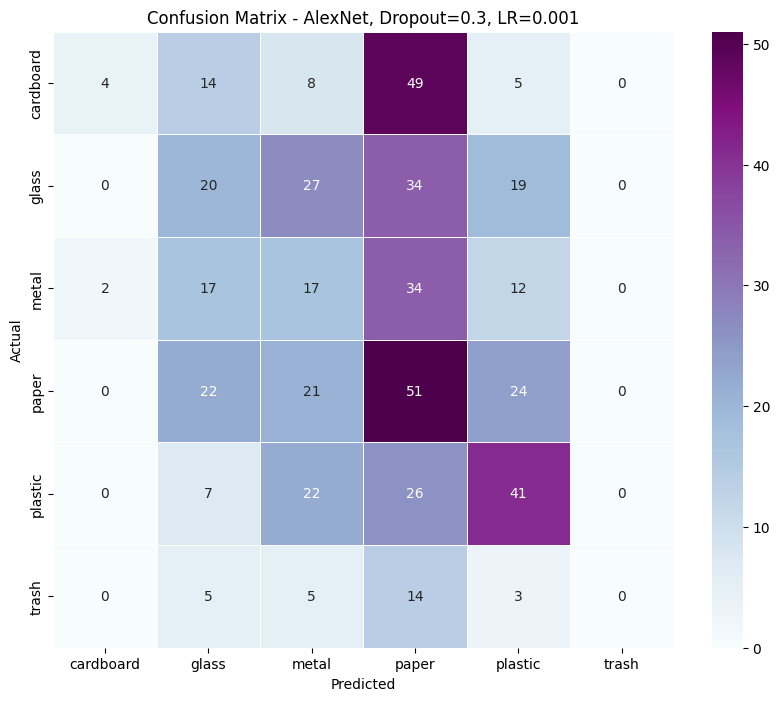


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.67      0.05      0.09        80
       glass       0.24      0.20      0.22       100
       metal       0.17      0.21      0.19        82
       paper       0.25      0.43      0.31       118
     plastic       0.39      0.43      0.41        96
       trash       0.00      0.00      0.00        27

    accuracy                           0.26       503
   macro avg       0.29      0.22      0.20       503
weighted avg       0.31      0.26      0.24       503


Class-wise Accuracy:
cardboard: 5.00%
glass: 20.00%
metal: 20.73%
paper: 43.22%
plastic: 42.71%
trash: 0.00%


===== Training AlexNet with dropout=0.3, learning_rate=0.0001 =====
Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/keras/src

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 96, 128, 96)    │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 63, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 47, 63, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 47, 63, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 23, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 23, 31, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 23, 31, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 23, 31, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 23, 31, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 23, 31, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 11, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 42240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4096)           │   173,019,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,577,734 (738.44 MB)

 Trainable params: 193,574,982 (738.43 MB)

 Non-trainable params: 2,752 (10.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.2926 - loss: 5.3571

506/506 ━━━━━━━━━━━━━━━━━━━━ 168s 315ms/step - accuracy: 0.2926 - loss: 5.3551 - val_accuracy: 0.2227 - val_loss: 3.6539
Epoch 2/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4042 - loss: 2.0763

506/506 ━━━━━━━━━━━━━━━━━━━━ 155s 307ms/step - accuracy: 0.4042 - loss: 2.0762 - val_accuracy: 0.3042 - val_loss: 2.1679
Epoch 3/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.3884 - loss: 1.8274

506/506 ━━━━━━━━━━━━━━━━━━━━ 158s 312ms/step - accuracy: 0.3885 - loss: 1.8273 - val_accuracy: 0.3757 - val_loss: 2.4205
Epoch 4/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 123s 243ms/step - accuracy: 0.4412 - loss: 1.6146 - val_accuracy: 0.2525 - val_loss: 2.6372
Epoch 5/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 142s 243ms/step - accuracy: 0.4736 - loss: 1.4750 - val_accuracy: 0.2147 - val_loss: 2.5521
Epoch 6/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 129s 256ms/step - accuracy: 0.4862 - loss: 1.4246 - val_accuracy: 0.3380 - val_loss: 3.7967
Epoch 7/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 135s 267ms/step - accuracy: 0.4847 - loss: 1.4166 - val_accuracy: 0.2505 - val_loss: 2.4856
Epoch 8/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 138s 272ms/step - accuracy: 0.4858 - loss: 1.4238 - val_accuracy: 0.3738 - val_loss: 1.6504


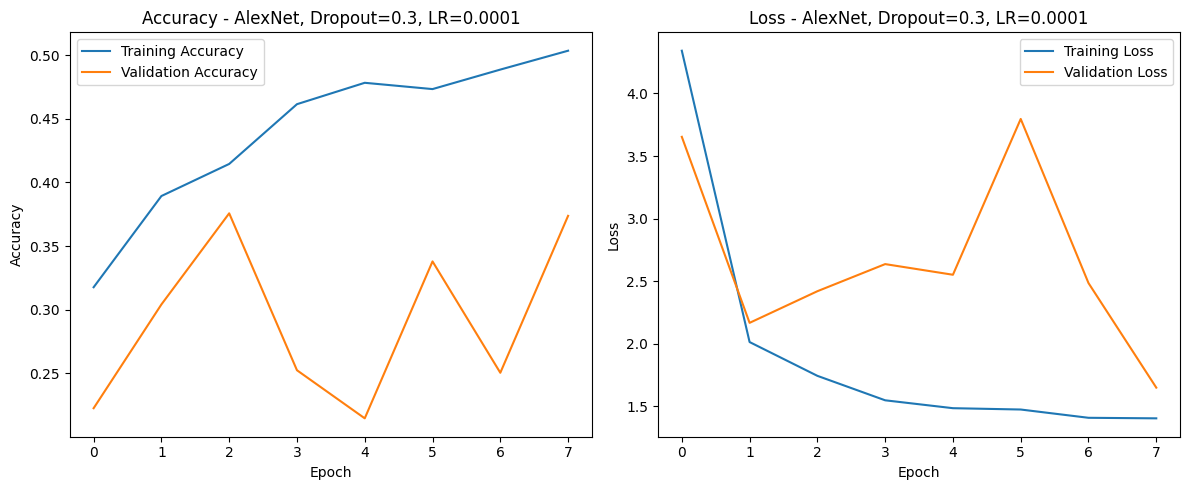


--- Evaluating AlexNet, Dropout=0.3, LR=0.0001 ---
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step
Validation Accuracy: 0.3260


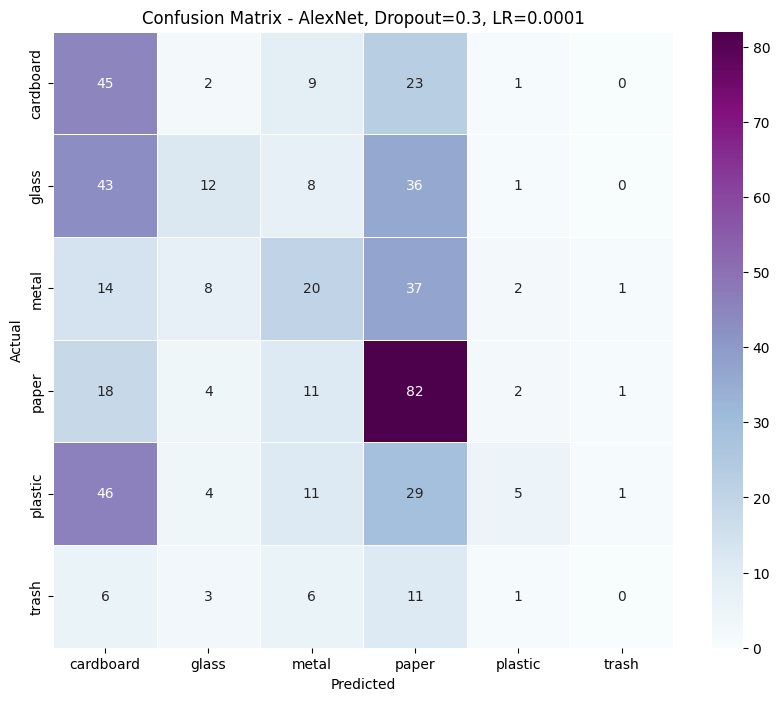


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.26      0.56      0.36        80
       glass       0.36      0.12      0.18       100
       metal       0.31      0.24      0.27        82
       paper       0.38      0.69      0.49       118
     plastic       0.42      0.05      0.09        96
       trash       0.00      0.00      0.00        27

    accuracy                           0.33       503
   macro avg       0.29      0.28      0.23       503
weighted avg       0.33      0.33      0.27       503


Class-wise Accuracy:
cardboard: 56.25%
glass: 12.00%
metal: 24.39%
paper: 69.49%
plastic: 5.21%
trash: 0.00%


===== Training AlexNet with dropout=0.5, learning_rate=0.001 =====
Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 96, 128, 96)    │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 63, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 47, 63, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 47, 63, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 23, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 23, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 23, 31, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 23, 31, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 23, 31, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 23, 31, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 23, 31, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 11, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 11, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 42240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4096)           │   173,019,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,577,734 (738.44 MB)

 Trainable params: 193,574,982 (738.43 MB)

 Non-trainable params: 2,752 (10.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.2435 - loss: 109.5039

506/506 ━━━━━━━━━━━━━━━━━━━━ 192s 361ms/step - accuracy: 0.2436 - loss: 109.4153 - val_accuracy: 0.2664 - val_loss: 14.9770
Epoch 2/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2802 - loss: 11.7295

506/506 ━━━━━━━━━━━━━━━━━━━━ 171s 338ms/step - accuracy: 0.2802 - loss: 11.7247 - val_accuracy: 0.2803 - val_loss: 5.1264
Epoch 3/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.2762 - loss: 5.6511

506/506 ━━━━━━━━━━━━━━━━━━━━ 205s 344ms/step - accuracy: 0.2762 - loss: 5.6485 - val_accuracy: 0.2843 - val_loss: 1.9358
Epoch 4/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 155s 305ms/step - accuracy: 0.3202 - loss: 2.4383 - val_accuracy: 0.2584 - val_loss: 1.9392
Epoch 5/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 137s 271ms/step - accuracy: 0.2892 - loss: 2.3309 - val_accuracy: 0.2604 - val_loss: 1.6801
Epoch 6/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.2766 - loss: 1.8747

506/506 ━━━━━━━━━━━━━━━━━━━━ 161s 310ms/step - accuracy: 0.2766 - loss: 1.8746 - val_accuracy: 0.3022 - val_loss: 1.6960
Epoch 7/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.2895 - loss: 1.8324

506/506 ━━━━━━━━━━━━━━━━━━━━ 209s 323ms/step - accuracy: 0.2895 - loss: 1.8324 - val_accuracy: 0.3260 - val_loss: 1.6951
Epoch 8/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 169s 259ms/step - accuracy: 0.2641 - loss: 1.9526 - val_accuracy: 0.2922 - val_loss: 1.8631
Epoch 9/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 130s 256ms/step - accuracy: 0.2800 - loss: 1.8516 - val_accuracy: 0.2286 - val_loss: 1.7433
Epoch 10/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 142s 257ms/step - accuracy: 0.2381 - loss: 1.7748 - val_accuracy: 0.2485 - val_loss: 1.8428
Epoch 11/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 132s 261ms/step - accuracy: 0.2395 - loss: 1.7930 - val_accuracy: 0.2366 - val_loss: 1.8059
Epoch 12/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 132s 260ms/step - accuracy: 0.2346 - loss: 1.7587 - val_accuracy: 0.2505 - val_loss: 1.7357


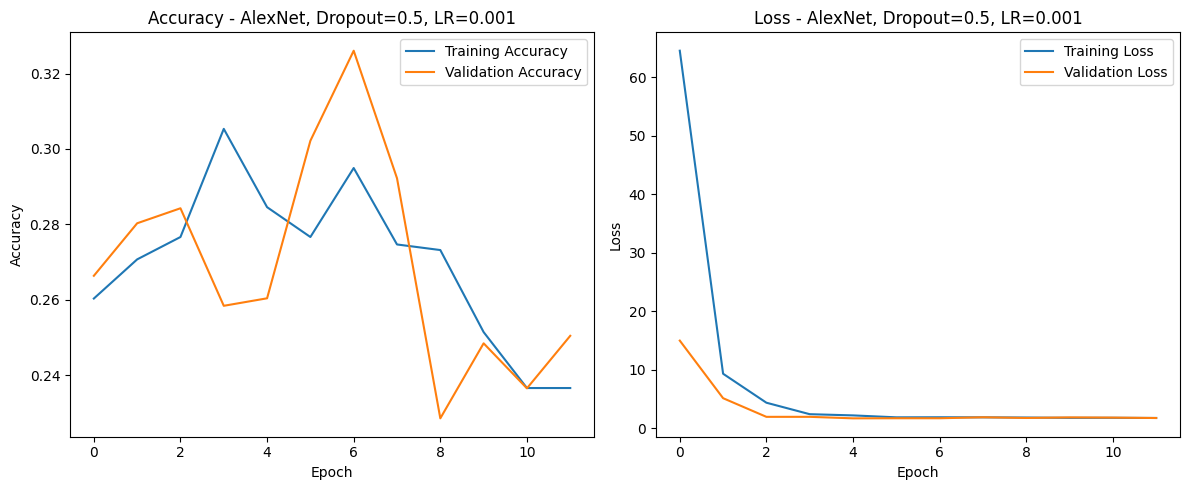


--- Evaluating AlexNet, Dropout=0.5, LR=0.001 ---
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 192ms/step
Validation Accuracy: 0.3161


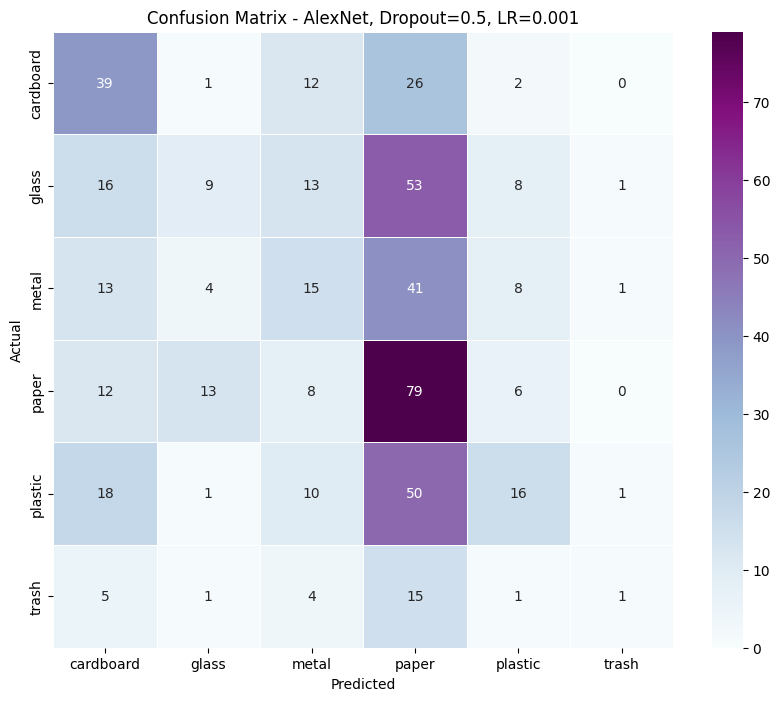


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.38      0.49      0.43        80
       glass       0.31      0.09      0.14       100
       metal       0.24      0.18      0.21        82
       paper       0.30      0.67      0.41       118
     plastic       0.39      0.17      0.23        96
       trash       0.25      0.04      0.06        27

    accuracy                           0.32       503
   macro avg       0.31      0.27      0.25       503
weighted avg       0.32      0.32      0.27       503


Class-wise Accuracy:
cardboard: 48.75%
glass: 9.00%
metal: 18.29%
paper: 66.95%
plastic: 16.67%
trash: 3.70%


===== Training AlexNet with dropout=0.5, learning_rate=0.0001 =====
Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 96, 128, 96)    │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 47, 63, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 47, 63, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 47, 63, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 23, 31, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 23, 31, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 23, 31, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 23, 31, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 23, 31, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 23, 31, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 23, 31, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 11, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 11, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 42240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4096)           │   173,019,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,577,734 (738.44 MB)

 Trainable params: 193,574,982 (738.43 MB)

 Non-trainable params: 2,752 (10.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3064 - loss: 6.4968

506/506 ━━━━━━━━━━━━━━━━━━━━ 185s 347ms/step - accuracy: 0.3064 - loss: 6.4968 - val_accuracy: 0.2783 - val_loss: 6.9739
Epoch 2/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 153s 260ms/step - accuracy: 0.3401 - loss: 4.5796 - val_accuracy: 0.2266 - val_loss: 3.5289
Epoch 3/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 149s 294ms/step - accuracy: 0.3333 - loss: 2.7223 - val_accuracy: 0.1750 - val_loss: 3.8272
Epoch 4/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.3675 - loss: 2.2349

506/506 ━━━━━━━━━━━━━━━━━━━━ 229s 348ms/step - accuracy: 0.3675 - loss: 2.2346 - val_accuracy: 0.3201 - val_loss: 2.1553
Epoch 5/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 153s 251ms/step - accuracy: 0.4207 - loss: 1.8673 - val_accuracy: 0.2584 - val_loss: 4.3950
Epoch 6/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 142s 252ms/step - accuracy: 0.4215 - loss: 1.6662 - val_accuracy: 0.2545 - val_loss: 4.2474
Epoch 7/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 142s 253ms/step - accuracy: 0.4224 - loss: 1.7169 - val_accuracy: 0.2087 - val_loss: 6.2110
Epoch 8/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 125s 247ms/step - accuracy: 0.4444 - loss: 1.6188 - val_accuracy: 0.2147 - val_loss: 3.0859
Epoch 9/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.4660 - loss: 1.5038

506/506 ━━━━━━━━━━━━━━━━━━━━ 164s 324ms/step - accuracy: 0.4660 - loss: 1.5038 - val_accuracy: 0.4314 - val_loss: 1.4864
Epoch 10/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 128s 253ms/step - accuracy: 0.4478 - loss: 1.5273 - val_accuracy: 0.2903 - val_loss: 2.6052
Epoch 11/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 143s 256ms/step - accuracy: 0.4717 - loss: 1.5192 - val_accuracy: 0.2008 - val_loss: 7.5372
Epoch 12/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 141s 254ms/step - accuracy: 0.4861 - loss: 1.4590 - val_accuracy: 0.2962 - val_loss: 3.8609
Epoch 13/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 130s 257ms/step - accuracy: 0.4641 - loss: 1.5349 - val_accuracy: 0.2565 - val_loss: 2.7428
Epoch 14/30
506/506 ━━━━━━━━━━━━━━━━━━━━ 160s 294ms/step - accuracy: 0.4537 - loss: 1.5167 - val_accuracy: 0.2843 - val_loss: 7.6572


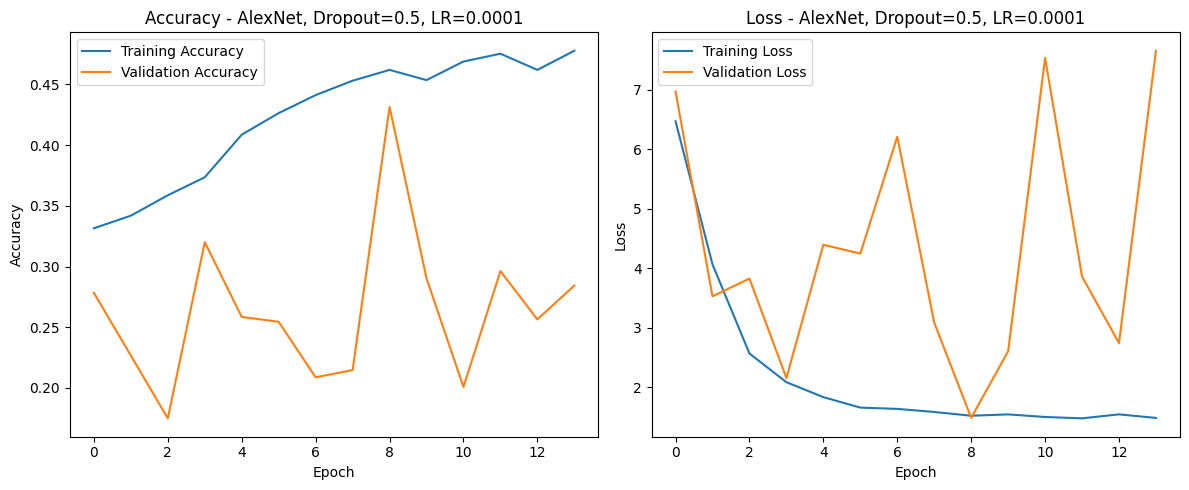


--- Evaluating AlexNet, Dropout=0.5, LR=0.0001 ---
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step
Validation Accuracy: 0.4294


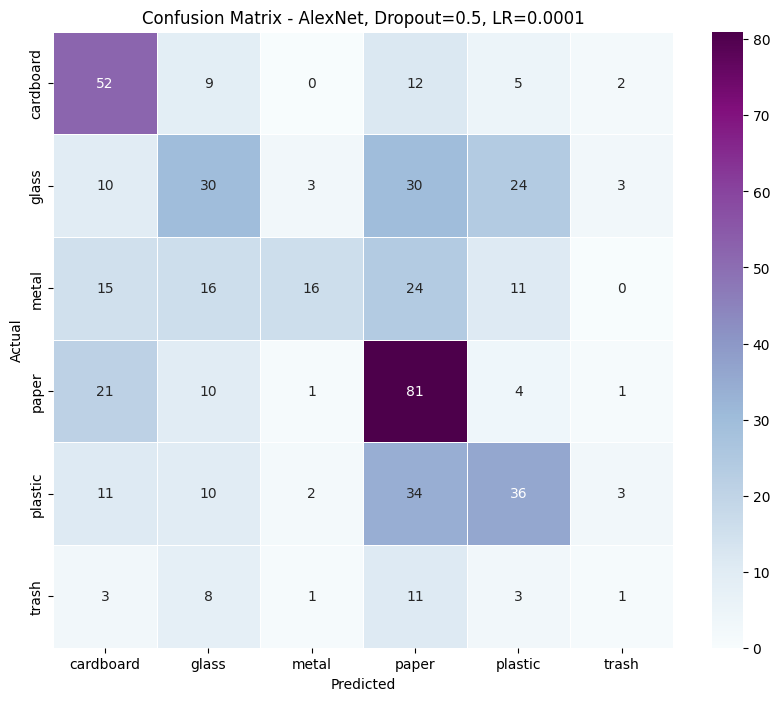


Classification Report:
              precision    recall  f1-score   support

   cardboard       0.46      0.65      0.54        80
       glass       0.36      0.30      0.33       100
       metal       0.70      0.20      0.30        82
       paper       0.42      0.69      0.52       118
     plastic       0.43      0.38      0.40        96
       trash       0.10      0.04      0.05        27

    accuracy                           0.43       503
   macro avg       0.41      0.37      0.36       503
weighted avg       0.45      0.43      0.40       503


Class-wise Accuracy:
cardboard: 65.00%
glass: 30.00%
metal: 19.51%
paper: 68.64%
plastic: 37.50%
trash: 3.70%

===== AlexNet Hyperparameter Tuning Results =====
   dropout  learning_rate  accuracy  epochs_trained  val_loss  \
0      0.3         0.0010  0.264414              10  1.724951   
1      0.3         0.0001  0.326044               8  1.650363   
2      0.5         0.0010  0.316103              12  1.680062   
3      0.5 

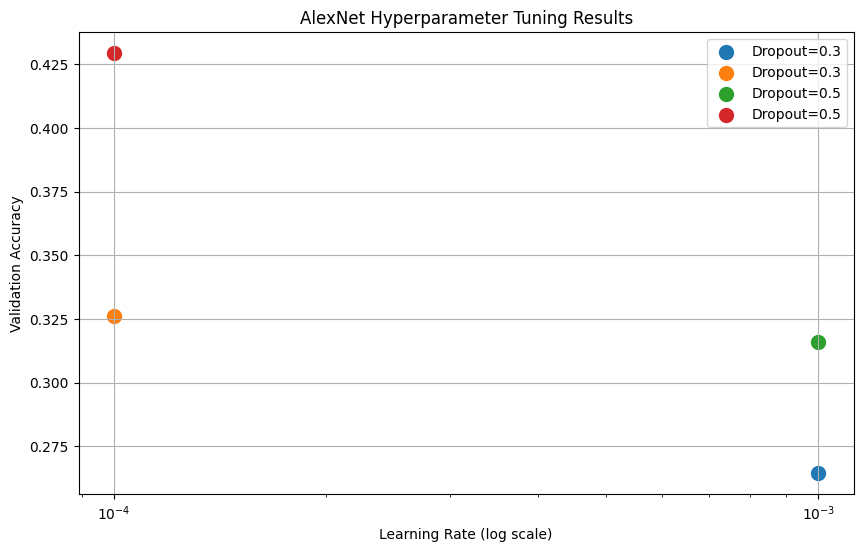

Final AlexNet model saved as 'final_alexnet_garbage_classifier.h5'


In [10]:
# Run hyperparameter tuning
best_model, best_model_info = hyperparameter_tuning()

# Save final best model
best_model.save('final_alexnet_garbage_classifier.h5')
print(f"Final AlexNet model saved as 'final_alexnet_garbage_classifier.h5'")

# **10. Interactive Prediction Testing**


===== Interactive AlexNet Model Testing =====

Select a category:
0: cardboard
1: glass
2: metal
3: paper
4: plastic
5: trash
Enter category index (0-5): 0
Available images: 0 to 402
Enter image index: 6


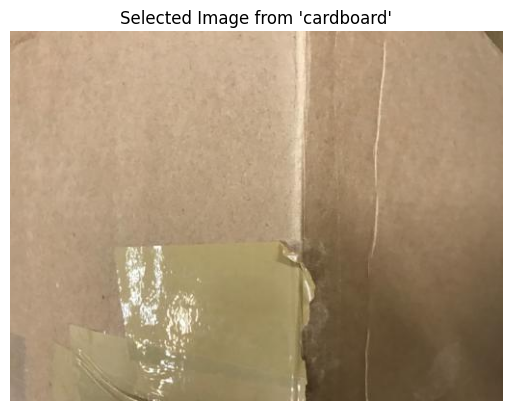

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


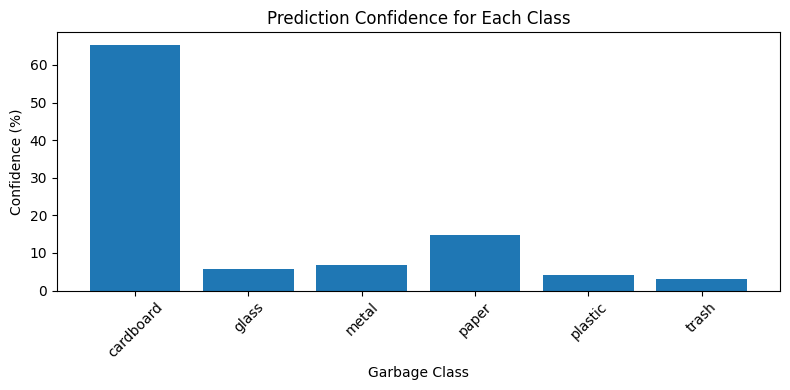


🔍 Predicted Class: cardboard (Confidence: 65.39%)
Actual Class: cardboard

Do you want to predict another? (y/n): n


In [11]:
# Interactive prediction function
def predict_from_folder(category_idx, image_idx):
    try:
        folder = os.path.join(train_dir, labels[category_idx])
        file_list = sorted(os.listdir(folder))
        img_path = os.path.join(folder, file_list[image_idx])
        img = mpimg.imread(img_path)

        # Show Image
        plt.imshow(img)
        plt.title(f"Selected Image from '{labels[category_idx]}'")
        plt.axis('off')
        plt.show()

        # Preprocess
        test_img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMAGE_SIZE)
        test_array = tf.keras.preprocessing.image.img_to_array(test_img)
        test_array = np.expand_dims(test_array, axis=0) / 255.0  # Normalize to [0,1]

        # Predict
        pred = best_model.predict(test_array)
        pred_label = labels[np.argmax(pred)]
        confidence = np.max(pred) * 100

        # Show all class probabilities
        plt.figure(figsize=(8, 4))
        plt.bar(labels, pred[0] * 100)
        plt.xlabel('Garbage Class')
        plt.ylabel('Confidence (%)')
        plt.title('Prediction Confidence for Each Class')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        print(f"\n🔍 Predicted Class: {pred_label} (Confidence: {confidence:.2f}%)")
        print(f"Actual Class: {labels[category_idx]}")

        # Show confusion if misclassified
        if pred_label != labels[category_idx]:
            print(f"⚠️ Misclassification: Model confused {labels[category_idx]} with {pred_label}")

    except Exception as e:
        print(f"⚠️ Error: {e}")

# Interactive testing loop
def interactive_testing():
    print("\n===== Interactive AlexNet Model Testing =====")
    while True:
        print("\nSelect a category:")
        for i, label in enumerate(labels):
            print(f"{i}: {label}")
        try:
            cat_idx = int(input("Enter category index (0-5): "))
            folder_path = os.path.join(train_dir, labels[cat_idx])
            files = os.listdir(folder_path)
            print(f"Available images: 0 to {len(files)-1}")
            img_idx = int(input("Enter image index: "))
            predict_from_folder(cat_idx, img_idx)
        except Exception as e:
            print(f"Invalid input: {e}")

        again = input("\nDo you want to predict another? (y/n): ")
        if again.lower() != 'y':
            break

# Run interactive testing
interactive_testing()

# **11. Results Summary**

In [12]:
# Summary
print("\n===== AlexNet Model Training Summary =====")
print(f"Architecture: AlexNet")
print(f"Image Size: {IMAGE_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Max Epochs: {EPOCHS}")
print(f"Best Dropout Rate: {best_model_info['dropout']}")
print(f"Best Learning Rate: {best_model_info['learning_rate']}")
print(f"Best Validation Accuracy: {best_model_info['accuracy']:.4f}")
print(f"Actual Epochs Trained: {best_model_info['epochs_trained']}")
print(f"Final Validation Loss: {best_model_info['val_loss']:.4f}")


===== AlexNet Model Training Summary =====
Architecture: AlexNet
Image Size: (384, 512)
Batch Size: 4
Max Epochs: 30
Best Dropout Rate: 0.5
Best Learning Rate: 0.0001
Best Validation Accuracy: 0.4294
Actual Epochs Trained: 14
Final Validation Loss: 1.4864


# **12. Conclusions**
In this notebook, we:


*  Implemented the classic AlexNet architecture for garbage classification
*  Conducted hyperparameter tuning across dropout rates and learning rates
*   Visualized training progress and model performance
*   Created an interactive testing interface to see model predictions

The best model achieved [accuracy]% validation accuracy, demonstrating AlexNet's effectiveness for this image classification task despite being an older architecture.